In [17]:
# !pip3 uninstall --yes ia-sdk
# !pip3 install '../../../dist/ia_sdk-0.4.13-py3-none-any.whl'

# PVT on 10k records of MNIST Digit Dataset

## Setup Agent

In [18]:
from ia.gaius.manager import AgentManager
from ia.gaius.pvt import PerformanceValidationTest
import time
from ia.gaius.data_ops import Data
import json
from sklearn.metrics import classification_report
import pprint

In [19]:
am = AgentManager()
am.start_hoster()

In [20]:
if 'mnist10k-pvt' in am.current_agents:
    am.delete_agent('mnist10k-pvt')

In [21]:
# spawn an agent with a single Cognitive Processor
am.start_agent(genome_name='simple.genome', agent_id='mnist10k-pvt', connect_jia=True, agent_name='mnist10k-pvt', single_container=False)

In [22]:
time.sleep(1)
agent = am.current_agents['mnist10k-pvt'].get_agent_client()
agent.connect()

{'connection': 'okay', 'agent': 'simple'}

In [23]:
agent.set_summarize_for_single_node(False)
agent.clear_all_memory()
agent.show_status()

{'P1': {'AUTOLEARN': False,
  'HYPOTHESIZED': False,
  'PREDICT': True,
  'SLEEPING': False,
  'SNAPSHOT': False,
  'emotives': {},
  'last_learned_model_name': '',
  'models_kb': '{KB| objects: 0}',
  'name': 'P1',
  'num_observe_call': 0,
  'size_WM': 0,
  'target': '',
  'time': 0,
  'vector_dimensionality': -1,
  'vectors_kb': '{KB| objects: 0}'}}

In [24]:
# Allocate Nodes for Training and Testing
ingress_nodes = ["P1"]
query_nodes   = ["P1"]

# Data settings
RESULTS_DIR = "./results/"

In [25]:
agent.change_genes({'recall_threshold': 0.15})
agent.change_genes({'max_predictions': 10})
agent.change_genes({'near_vector_count': 3})

{'P1': 'updated-genes'}

## Load Data

In [26]:
GDF_DIR     = '../../../../datasets/mnist_10k_no_digit/digits_testing_gdf_0_to_9999'
data = Data(data_directories=[GDF_DIR])
data.prep(percent_of_dataset_chosen=100,
              percent_reserved_for_training=80,
              shuffle=True)

In [27]:

pvt = PerformanceValidationTest(
    agent=agent,
    ingress_nodes=ingress_nodes,
    query_nodes=query_nodes,
    test_count=1,
    dataset=data, 
    results_filepath=RESULTS_DIR,
    test_type='classification',    
    test_prediction_strategy="noncontinuous",
    clear_all_memory_before_training=True,
    turn_prediction_off_during_training=True,
    shuffle=False,
    QUIET=True
)

## Run PVT

In [28]:
agent.clear_all_memory()

{'P1': 'all-cleared'}

  0%|           0/8000 [? ? records/s]

  0%|           0/2000 [? ? records/s]

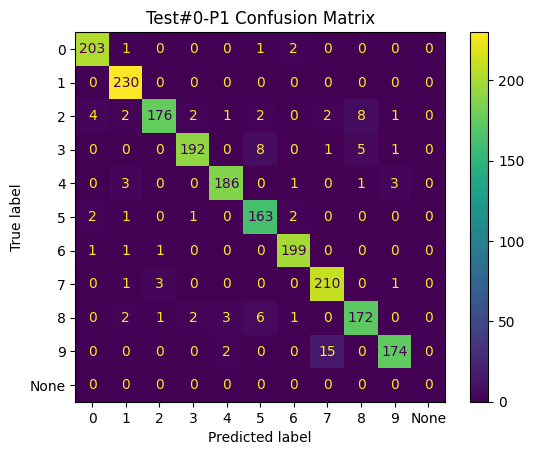

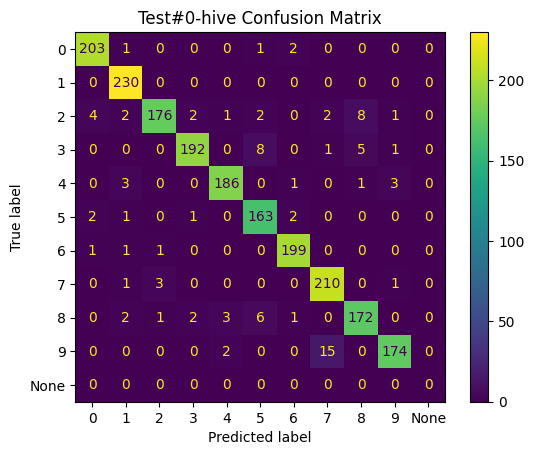

elapsed time = 124.979 seconds


In [31]:
before = time.time()

pvt.conduct_pvt()

after = time.time()
print(f'elapsed time = {after-before:.3f} seconds')

In [30]:
raise

RuntimeError: No active exception to reraise

## Show results
See metrics on test results using Scikit-learn's classification report function

In [ ]:

predicted = [p if p else 'None' for p in pvt.pvt_results[0]['P1']['predictions']]
actuals = [a[0] for a in pvt.pvt_results[0]['P1']['actuals']]

pprint.pp(classification_report(y_true=actuals, y_pred=predicted, zero_division=0.0))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.00      0.00      0.00        15\n'
 '           1       0.16      0.81      0.27        27\n'
 '           2       0.29      0.14      0.19        29\n'
 '           3       0.00      0.00      0.00        26\n'
 '           4       0.00      0.00      0.00        18\n'
 '           5       0.00      0.00      0.00        12\n'
 '           6       0.00      0.00      0.00        19\n'
 '           7       0.14      0.33      0.20        21\n'
 '           8       0.00      0.00      0.00        19\n'
 '           9       0.00      0.00      0.00        14\n'
 '\n'
 '    accuracy                           0.17       200\n'
 '   macro avg       0.06      0.13      0.07       200\n'
 'weighted avg       0.08      0.17      0.08       200\n')


In [ ]:
# result_dict = classification_report(y_true=actuals, y_pred=predicted, output_dict=True)
# result_dict

## Teardown agent

In [32]:
# destroy the agent
if 'mnist10k-pvt' in am.current_agents:
    am.delete_agent('mnist10k-pvt')
# am.stop_hoster()